# Sobre o Conjunto de Dados

#### Este conjunto de dados é originalmente do Instituto Nacional de Diabetes e Doenças Digestivas e Renais; O objetivo do conjunto de dados é prever de forma diagnóstica se um paciente tem diabetes, com base em certas medidas de diagnóstico incluídas no conjunto de dados. Várias restrições foram colocadas na seleção dessas instâncias de um banco de dados maior. Em particular, todos os pacientes aqui são mulheres com pelo menos 21 anos de idade, descendentes dos índios Pima.2 A partir dos dados do arquivo (.csv) Podemos encontrar várias variáveis, algumas delas são independentes (várias variáveis preditivas médicas) e apenas uma variável dependente de destino (resultado).

#### Sobre este arquivo
###### Informações sobre atributos do conjunto de dados

- Gravidez: Para expressar o número de gestações

- Glicose: Para expressar o nível de glicose no sangue

- BloodPressure: Para expressar a medição da pressão arterial

- SkinThickness: Para expressar a espessura da pele

- Taxa de insulina: Para expressar o nível de insulina no sangue

- IMC: Para expressar o índice de massa corporal

- DiabetesPedigreeFunction: Para expressar a porcentagem de Diabetes

- Idade: Para expressar a idade

- Resultado: Para expressar o resultado final 1 é Sim e 0 é Não

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./diabetes.csv', sep = ",")

### Limpando os dados a seguir(Extraction and Cleaning of the data)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1


### Analisando e Visualizando os dados 

A principio vamos considerar os fatores que já sabemos que influenciam no fator diabético.

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sbn 

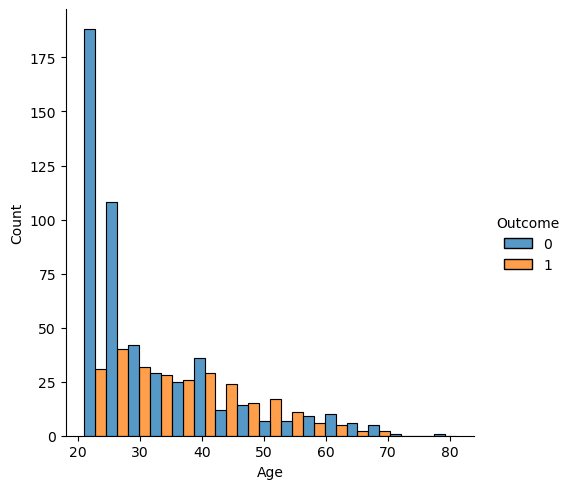

In [12]:
sbn.displot(df, x="Age", hue="Outcome", multiple = "dodge")
plt.show()

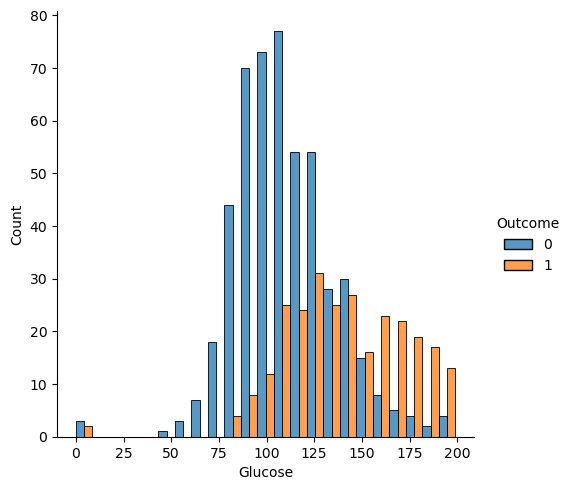

In [13]:
sbn.displot(df, x="Glucose", hue='Outcome', multiple = "dodge")
plt.show()

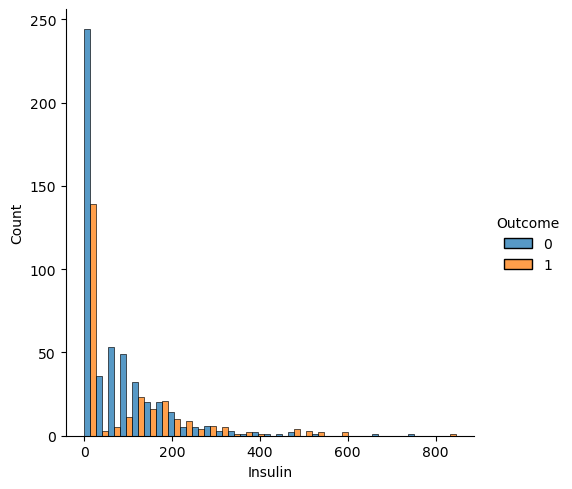

In [17]:
# sbn.catplot(data=df, kind="bar", x="Age", y = "DiabetesPedigreeFunction",hue="Outcome")
sbn.displot(df, x="Insulin", hue="Outcome", multiple = "dodge")
plt.show()

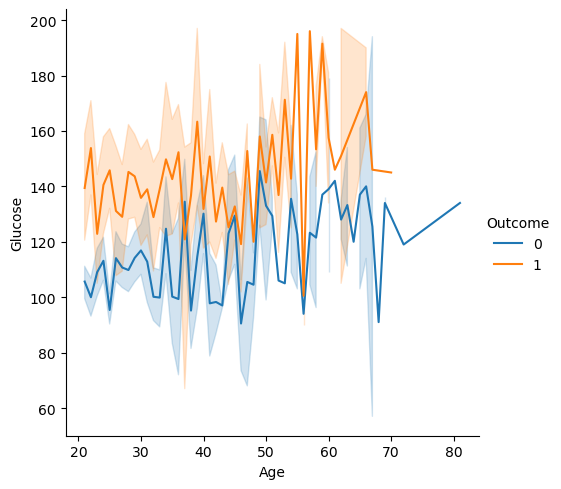

In [14]:
sbn.relplot(data=df, x="Age", y="Glucose", hue="Outcome", kind='line')
plt.show()

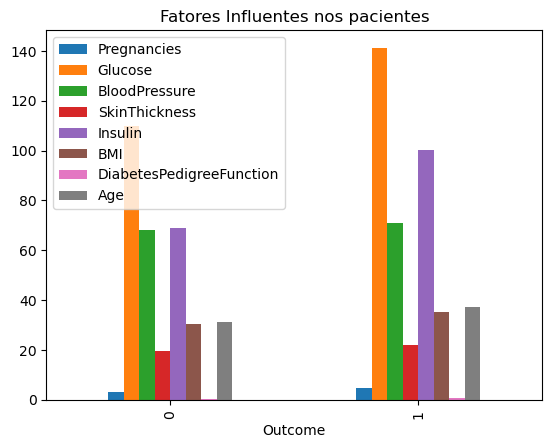

In [22]:
df_diff = df.groupby(by=['Outcome'])\
    .mean()\
    .multiply(1)

df_diff.plot(kind='bar', title='Fatores Influentes nos pacientes')
plt.show()

C:\Users\wesle\AppData\Local\Temp\ipykernel_1696\1683509982.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = df.groupby(by=['Outcome'])['Glucose','Insulin','BloodPressure']\


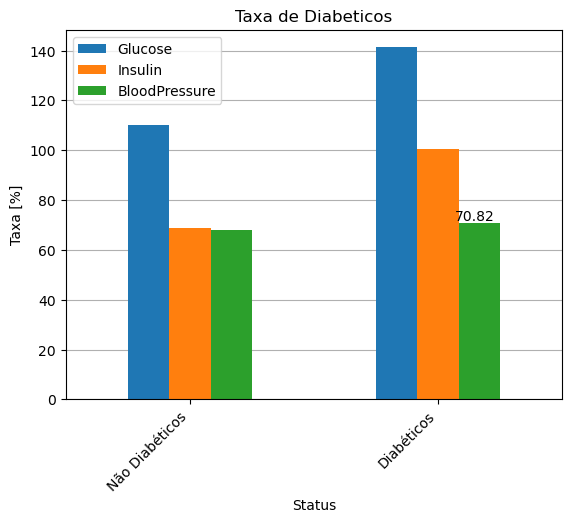

In [19]:
# Taxa de Sobrevivencia de pessoas com problemas prévios respiratórios 
ax = df.groupby(by=['Outcome'])['Glucose','Insulin','BloodPressure']\
    .mean()\
    .multiply(1)\
    .plot.bar(title='Taxa de Diabeticos')
    
plt.ylabel('Taxa [%]')
plt.xlabel('Status')
plt.xticks([0,1],['Não Diabéticos','Diabéticos'], rotation= 45, ha='right')
ax.set_axisbelow(True)
plt.grid(axis='y')

x_offset = -.1
y_offset = 0.9

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)
    
ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
plt.show()

### Um teste de Correlação para ratificar as variaveis influentes 

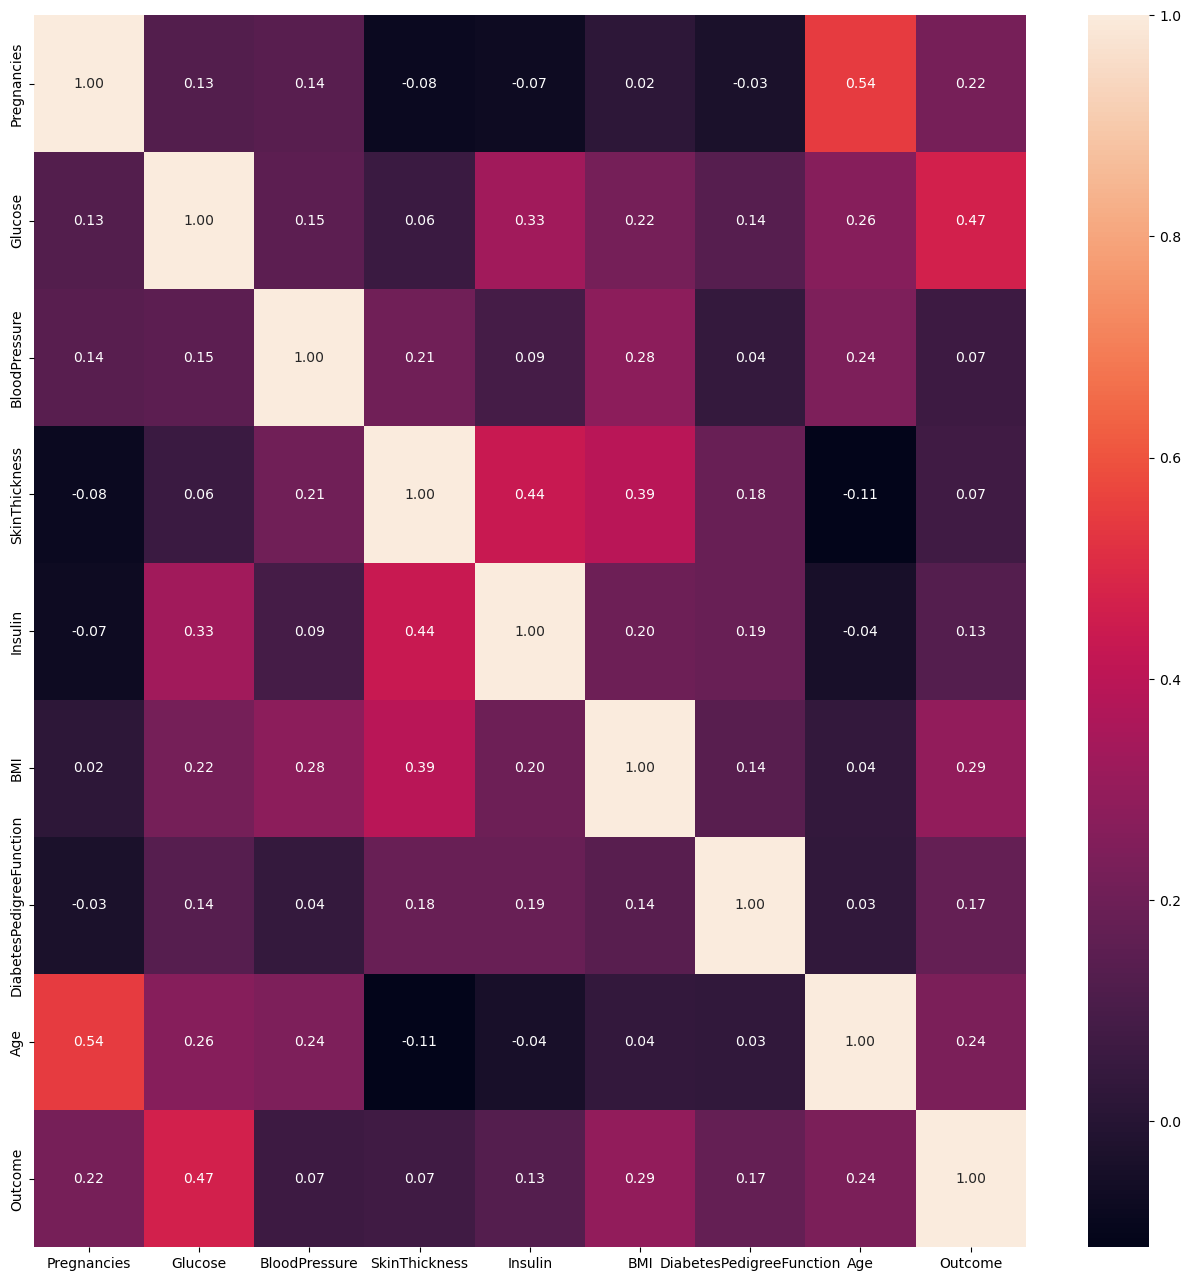

In [20]:
plt.figure(figsize=(16,16))
sbn.heatmap(data=df.corr(), annot=True, fmt=".2f");
plt.show()

## Modelagem e Machine Learning

In [23]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [25]:
from sklearn.model_selection import train_test_split

# Criamos então a variável “y” com os dados da coluna “target”, ou seja, os dados que iremos prever. Criamos também a variável “x” com as demais colunas do dataset, que são as variáveis preditoras.

x = df.drop("Outcome", axis = 1)
y = df['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y)

print(x_train.shape, 
      x_test.shape, 
      y_train.shape,
      y_test.shape)

(460, 8) (308, 8) (460,) (308,)


In [26]:
# ExtraTrees, que criará várias árvores de decisão
# Este algoritmo está pronto para ser utilizado 
# sendo que precisamos apenas indicar sua função
# Como estamos trabalhando em um problema de classificação utilizaremos a função “ExtraTreesClassifier()”.

from sklearn.ensemble import ExtraTreesClassifier

model_decisiontree = ExtraTreesClassifier()

model_decisiontree.fit(x_train,y_train)

acc_decisiontree = round(model_decisiontree.score(x_test, y_test)*100,2)

acc_decisiontree

73.7

In [27]:
explainer_model_decisiontree = shap.TreeExplainer(model_decisiontree)
shap_test_model_decisiontree = explainer_model_decisiontree.shap_values(x_test)

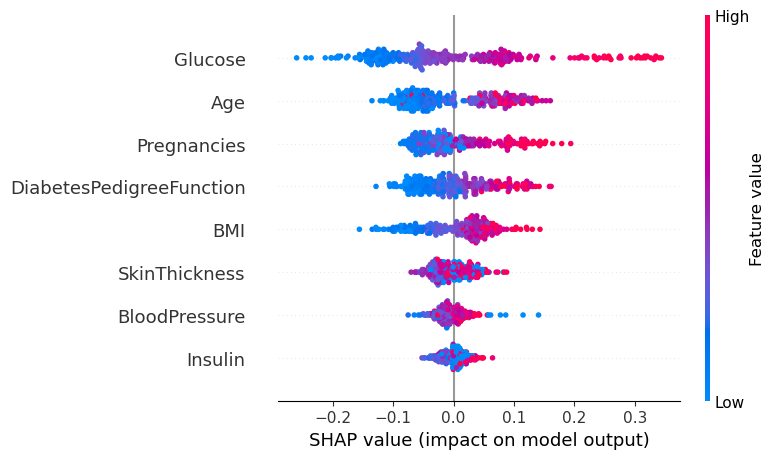

In [31]:
shap.summary_plot(shap_test_model_decisiontree[1], x_test)

### Modelo de Arvore de decisão
Baseado na plotagem anterior vamos treinar um novo modelo com as variaveis mais influentes

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [34]:
X = x_train[['Glucose', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction', 'BMI', 'SkinThickness']]
Y = y_train
treeClf = DecisionTreeClassifier().fit(X, Y)
pred_clf = treeClf.predict(x_test[['Glucose', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction', 'BMI', 'SkinThickness']])
# accuracy = accuracy_score(y_test, pred_clf)*100
# precision_score = precision_score(y_test, pred_clf)*100
# recall_score = recall_score(y_test, pred_clf)*100

models = pd.DataFrame({
    'Model': ['Acurácia', 'Precisão', 
              'Recall Score'],
    'Score': [accuracy_score(y_test, pred_clf)*100, precision_score(y_test, pred_clf)*100, 
              recall_score(y_test, pred_clf)*100]})

models.sort_values(by='Score', ascending=False)

,Model,Score
0,Acurácia,67.532468
1,Precisão,52.631579
2,Recall Score,47.619048


In [35]:
explainer_model_tree = shap.TreeExplainer(treeClf)
shap_model_tree = explainer_model_tree.shap_values(x_test)

In [36]:
shap.force_plot(explainer_model_decisiontree.expected_value[1], shap_test_model_decisiontree[0][0,:], x_test.iloc[0,:])

## Voltamos a fazer plotagem da correlação dos dados 

In [37]:
df_train = pd.concat([x_train, y_train], axis=1)
print(df_train.shape)
df_train.head()

(460, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
715,7,187,50,33,392,33.9,0.826,34,1
540,8,100,74,40,215,39.4,0.661,43,1
16,0,118,84,47,230,45.8,0.551,31,1
463,5,88,78,30,0,27.6,0.258,37,0
479,4,132,86,31,0,28.0,0.419,63,0


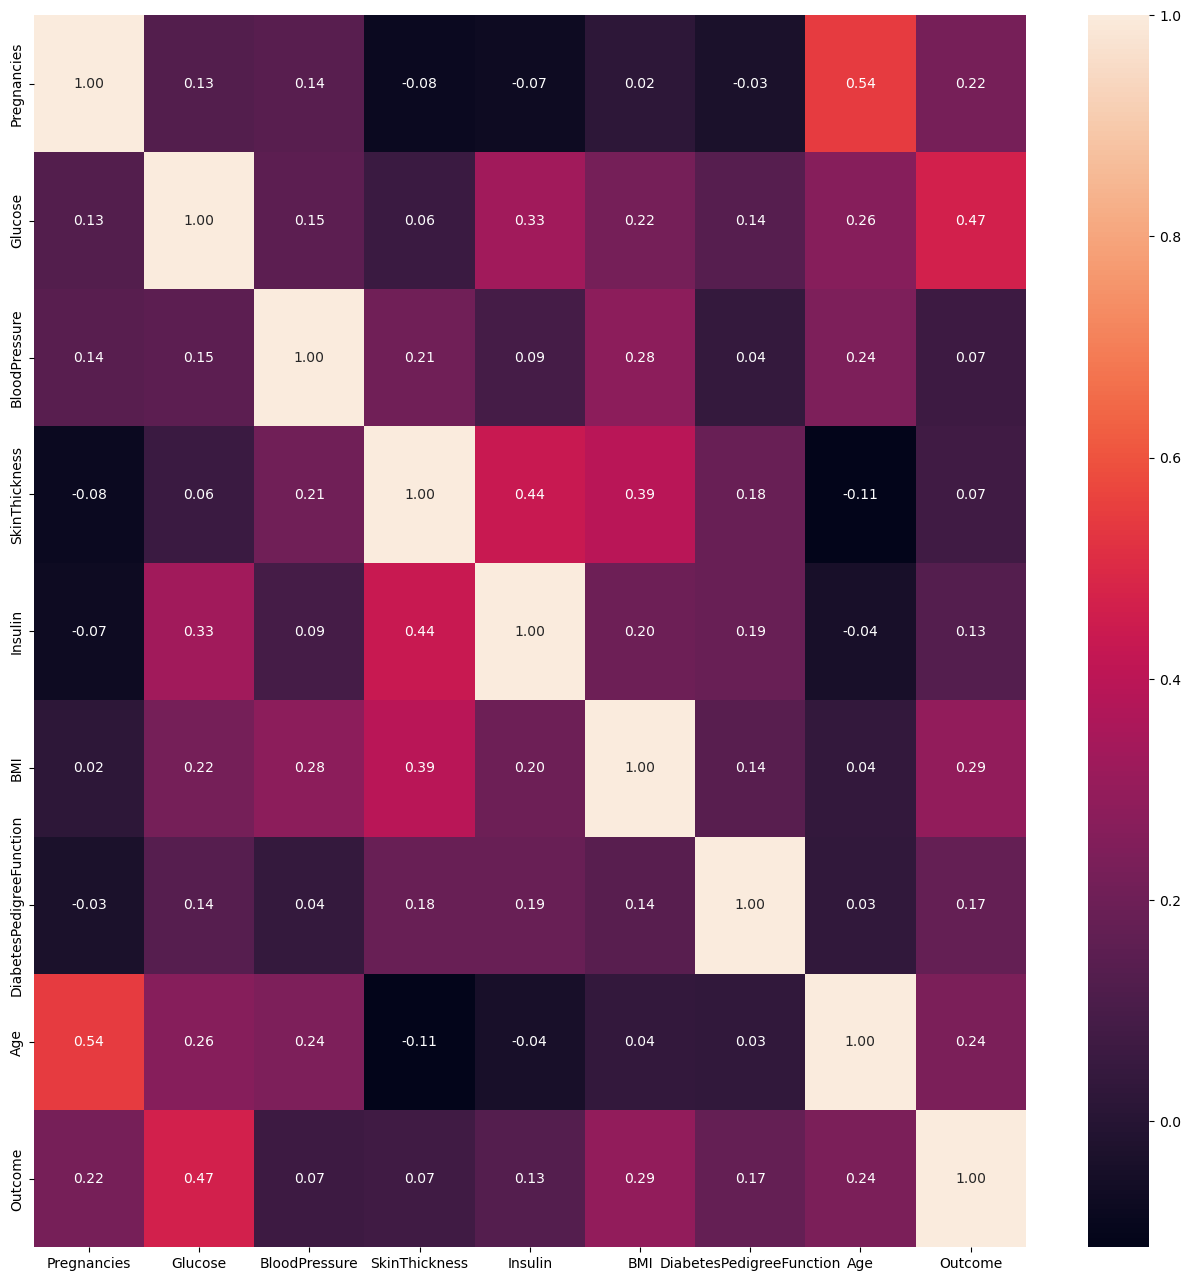

In [38]:
plt.figure(figsize=(16,16))
sbn.heatmap(data=df.corr(), annot=True, fmt=".2f");
plt.show()